In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
from collections import deque, OrderedDict
import random
from copy import deepcopy

class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)

        # Initialize weights
        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x, thompson_probs=None):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        action_probs = F.softmax(self.fc5(x), dim=-1)

        # Incorporate Thompson sampling probabilities
        if thompson_probs is not None:
            action_probs = action_probs * thompson_probs
            action_probs = action_probs / (action_probs.sum() + 1e-10)

        return action_probs

class MetaPolicy:
    def __init__(self, policy):
        self.policy = policy
        self.params = OrderedDict(policy.named_parameters())

    def update_params(self, loss, step_size=0.1, first_order=False):
        grads = torch.autograd.grad(loss, self.params.values(),
                                    create_graph=not first_order)
        updated_params = OrderedDict()
        for (name, param), grad in zip(self.params.items(), grads):
            updated_params[name] = param - step_size * grad.clamp(-1, 1)  # Gradient clipping
        return updated_params

    def set_params(self, params):
        for name, param in self.policy.named_parameters():
            param.data = params[name].data.clone()

class ThompsonMAML:
    def __init__(self, state_dim, action_dim, hidden_dim=256,
                 inner_lr=0.01, meta_lr=0.001,
                 num_tasks=5, k_shots=20,
                 memory_size=10000, batch_size=1024,
                 gamma=0.99, epsilon=0.1):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy = PolicyNetwork(state_dim, hidden_dim, action_dim).to(self.device)
        self.meta_policy = MetaPolicy(self.policy)
        self.meta_optimizer = optim.Adam(self.policy.parameters(), lr=meta_lr)

        self.inner_lr = inner_lr

        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size

        self.gamma = gamma
        self.epsilon = epsilon
        self.num_tasks = num_tasks
        self.k_shots = k_shots
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.epsilon = 0.5
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.99

        # Reward normalization using moving averages
        self.reward_mean = 0
        self.reward_std = 1
        self.reward_ema_alpha = 0.1  # Smoothing factor for exponential moving average

        self.alpha = np.ones(action_dim) * 1.0
        self.beta = np.ones(action_dim) * 1.0

        # Add reward scaling
        self.reward_scale = 0.1

        # Episode statistics
        self.current_episode_length = 0
        self.max_episode_length = 500  # Typical max length for CartPole

    def select_action(self, state, thompson=True):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)

            if thompson:
                # Sample Thompson probabilities
                thompson_probs = np.array([np.random.beta(self.alpha[i], self.beta[i])
                                           for i in range(self.action_dim)])
                thompson_probs = torch.FloatTensor(thompson_probs).to(self.device)

                # Get policy probabilities incorporating Thompson sampling
                probs = self.policy(state, thompson_probs).cpu().numpy()[0]
            else:
                probs = self.policy(state).cpu().numpy()[0]

            if random.random() < self.epsilon:
                return random.randrange(self.action_dim)
            return np.argmax(probs)

    def normalize_reward(self, reward):
        self.reward_mean = (1 - self.reward_ema_alpha) * self.reward_mean + self.reward_ema_alpha * reward
        self.reward_std = (1 - self.reward_ema_alpha) * self.reward_std + self.reward_ema_alpha * abs(reward - self.reward_mean)
        return (reward - self.reward_mean) / (self.reward_std + 1e-8)

    def store_transition(self, state, action, reward, next_state, done):
        # Normalize rewards before storing
        normalized_reward = self.normalize_reward(reward)
        self.memory.append((state, action, normalized_reward, next_state, done))

        self.current_episode_length += 1

        # Balanced Thompson updates
        if done:
            success = self.current_episode_length >= self.max_episode_length
            update_value = self.reward_scale * (1.0 if success else 0.0)

            self.alpha[action] += update_value
            self.beta[action] += (1.0 - update_value)

            self.current_episode_length = 0
        else:
            # Smaller intermediate updates
            step_reward = max(0, reward * self.reward_scale * 0.1)
            self.alpha[action] += step_reward
            self.beta[action] += (1.0 - step_reward) * 0.1

    def prepare_batch(self, batch):
        states = torch.FloatTensor([t[0] for t in batch]).to(self.device)
        actions = torch.LongTensor([t[1] for t in batch]).to(self.device)
        rewards = torch.FloatTensor([t[2] for t in batch]).to(self.device)
        next_states = torch.FloatTensor([t[3] for t in batch]).to(self.device)
        dones = torch.FloatTensor([t[4] for t in batch]).to(self.device)
        return states, actions, rewards, next_states, dones

    def compute_loss(self, states, actions, rewards, policy=None):
        if policy is None:
            policy = self.policy

        # Scale rewards for loss computation
        scaled_rewards = rewards * self.reward_scale

        thompson_probs = np.array([[np.random.beta(self.alpha[i], self.beta[i])
                                    for i in range(self.action_dim)]
                                   for _ in range(states.size(0))])
        thompson_probs = torch.FloatTensor(thompson_probs).to(self.device)

        probs = policy(states, thompson_probs)
        log_probs = torch.log(probs + 1e-10)
        action_log_probs = log_probs.gather(1, actions.unsqueeze(1)).squeeze()

        # Increased entropy coefficient for better exploration
        entropy = -(probs * log_probs).sum(-1).mean()

        return -(action_log_probs * scaled_rewards).mean() - 0.05 * entropy

    def inner_loop_update(self, task_batch):
        states, actions, rewards, _, _ = self.prepare_batch(task_batch)
        loss = self.compute_loss(states, actions, rewards)
        return self.meta_policy.update_params(loss, self.inner_lr)

    def meta_update(self):
        if len(self.memory) < self.batch_size * 2:
            return

        self.meta_optimizer.zero_grad()
        meta_loss = 0

        for _ in range(self.num_tasks):
            start_idx = random.randint(0, len(self.memory) - self.batch_size * 2)
            task_batch = list(self.memory)[start_idx:start_idx + self.batch_size]
            eval_batch = list(self.memory)[start_idx + self.batch_size:start_idx + self.batch_size * 2]

            updated_params = self.inner_loop_update(task_batch)
            states, actions, rewards, _, _ = self.prepare_batch(eval_batch)

            old_params = OrderedDict((name, param.clone())
                                     for name, param in self.policy.named_parameters())
            self.meta_policy.set_params(updated_params)

            task_meta_loss = self.compute_loss(states, actions, rewards)
            meta_loss += task_meta_loss

            self.meta_policy.set_params(old_params)

        meta_loss = meta_loss / self.num_tasks
        meta_loss.backward()

        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
        self.meta_optimizer.step()

    def log_thompson_params(self):
      means = self.alpha / (self.alpha + self.beta)
      variances = (self.alpha * self.beta) / ((self.alpha + self.beta) ** 2 * (self.alpha + self.beta + 1))
      print(f"Thompson Params - Alpha: {self.alpha}, Beta: {self.beta}")
      print(f"Action Means: {means}, Action Variances: {variances}")

def train(env_name='CartPole-v1', episodes=1000, max_steps=500):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ThompsonMAML(state_dim, action_dim)
    scores = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            #print("REWARDS", reward)

            agent.store_transition(state, action, reward, next_state, done)

            if len(agent.memory) >= agent.batch_size * 2:
                agent.meta_update()

            total_reward += reward
            state = next_state

            if done:
                break
        scores.append(total_reward)

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        print(scores[-10:])
        if (episode + 1) % 10 == 0:
            avg_score = np.mean(scores[-10:])
            print(f"Episode {episode + 1}, Average Score: {avg_score:.2f}")
            print(f"Thompson params - Alpha: {agent.alpha}, Beta: {agent.beta}")

            if avg_score >= 195.0:
                print(f"Environment solved in {episode + 1} episodes!")
                break
            agent.log_thompson_params()  # Log means and variances

    return agent, scores

if __name__ == "__main__":
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    agent, scores = train(episodes=1000)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(scores)
    plt.title('Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')

    plt.subplot(1, 2, 2)
    x = np.linspace(0, 1, 100)
    for i in range(agent.action_dim):
        plt.hist(np.random.beta(agent.alpha[i], agent.beta[i], 1000),
                bins=30, alpha=0.5, label=f'Action {i}')
    plt.title('Thompson Sampling Distributions')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()


[13.0]
[13.0, 14.0]
[13.0, 14.0, 10.0]
[13.0, 14.0, 10.0, 28.0]
[13.0, 14.0, 10.0, 28.0, 33.0]
[13.0, 14.0, 10.0, 28.0, 33.0, 11.0]
[13.0, 14.0, 10.0, 28.0, 33.0, 11.0, 23.0]
[13.0, 14.0, 10.0, 28.0, 33.0, 11.0, 23.0, 13.0]
[13.0, 14.0, 10.0, 28.0, 33.0, 11.0, 23.0, 13.0, 10.0]
[13.0, 14.0, 10.0, 28.0, 33.0, 11.0, 23.0, 13.0, 10.0, 27.0]
Episode 10, Average Score: 18.20
Thompson params - Alpha: [1.86 1.86], Beta: [15.514 13.514]
Thompson Params - Alpha: [1.86 1.86], Beta: [15.514 13.514]
Action Means: [0.10705652 0.12098348], Action Variances: [0.00520276 0.00649484]
[14.0, 10.0, 28.0, 33.0, 11.0, 23.0, 13.0, 10.0, 27.0, 33.0]
[10.0, 28.0, 33.0, 11.0, 23.0, 13.0, 10.0, 27.0, 33.0, 33.0]
[28.0, 33.0, 11.0, 23.0, 13.0, 10.0, 27.0, 33.0, 33.0, 12.0]
[33.0, 11.0, 23.0, 13.0, 10.0, 27.0, 33.0, 33.0, 12.0, 24.0]
[11.0, 23.0, 13.0, 10.0, 27.0, 33.0, 33.0, 12.0, 24.0, 27.0]
[23.0, 13.0, 10.0, 27.0, 33.0, 33.0, 12.0, 24.0, 27.0, 21.0]
[13.0, 10.0, 27.0, 33.0, 33.0, 12.0, 24.0, 27.0, 21.0, 23.0]

KeyboardInterrupt: 

In [1]:
'''THE GROKFAST IMPLEMENTATION

see https://github.com/ironjr/grokfast for a reference
there also is a accompanying paper
'''

from collections import deque
from typing import Dict, Optional, Literal
import torch
import torch.nn as nn


def gradfilter_ma(
    m: nn.Module,
    grads: Optional[Dict[str, deque]] = None,
    window_size: int = 100,
    lamb: float = 5.0,
    filter_type: Literal['mean', 'sum'] = 'mean',
    warmup: bool = True,
    trigger: bool = False, # For ablation study.
) -> Dict[str, deque]:
    if grads is None:
        grads = {n: deque(maxlen=window_size) for n, p in m.named_parameters() if p.requires_grad and p.grad is not None}

    for n, p in m.named_parameters():
        if p.requires_grad and p.grad is not None:
            grads[n].append(p.grad.data.detach()) # .cpu())

            # Modify the gradients.
            if not warmup or len(grads[n]) == window_size and not trigger:
                if filter_type == "mean":
                    avg = sum(grads[n]) / len(grads[n])
                elif filter_type == "sum":
                    avg = sum(grads[n])
                else:
                    raise ValueError(f"Unrecognized filter_type {filter_type}")
                p.grad.data = p.grad.data + avg * lamb

    return grads


def gradfilter_ema(
    m: nn.Module,
    grads: Optional[Dict[str, torch.Tensor]] = None,
    alpha: float = 0.98,
    lamb: float = 2.0,
) -> Dict[str, torch.Tensor]:
    if grads is None:
        grads = {n: p.grad.data.detach() for n, p in m.named_parameters() if p.requires_grad and p.grad is not None}

    for n, p in m.named_parameters():
        if p.requires_grad and p.grad is not None:
            grads[n] = grads[n] * alpha + p.grad.data.detach() * (1 - alpha)
            p.grad.data = p.grad.data + grads[n] * lamb

    return grads

Episode 10, Average Score: 22.5
Episode 20, Average Score: 38.8
Episode 30, Average Score: 199.6
Episode 40, Average Score: 188.7
Episode 50, Average Score: 181.6
Episode 60, Average Score: 197.8
Episode 70, Average Score: 193.3
Episode 80, Average Score: 9.5
Episode 90, Average Score: 9.5
Episode 100, Average Score: 19.9
Episode 110, Average Score: 10.7
Episode 120, Average Score: 9.9
Episode 130, Average Score: 148.4
Episode 140, Average Score: 151.4
Episode 150, Average Score: 122.5
Episode 160, Average Score: 187.0
Episode 170, Average Score: 129.9
Episode 180, Average Score: 148.1
Episode 190, Average Score: 106.7
Episode 200, Average Score: 60.2
Episode 210, Average Score: 160.2
Episode 220, Average Score: 353.3
Episode 230, Average Score: 324.6
Episode 240, Average Score: 318.0
Solved at Episode 242


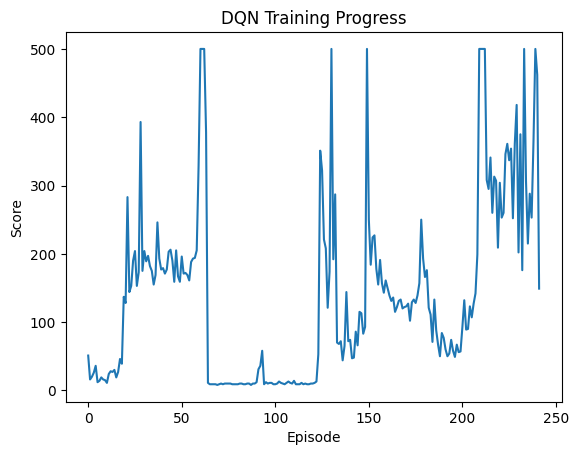

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
from collections import deque
import random

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Outputs Q-values for each action

class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=256,
                 gamma=0.99, epsilon=1.0, epsilon_min=0.1,
                 epsilon_decay=0.995, lr=0.001, batch_size=64,
                 memory_size=10000, target_update_freq=10):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        # Main Q-Network and Target Q-Network
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.memory = deque(maxlen=memory_size)
        self.learn_step_counter = 0

    def select_action(self, state, greedy=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if greedy or random.random() > self.epsilon:
            with torch.no_grad():
                return torch.argmax(self.q_network(state)).item()
        else:
            return random.randrange(self.action_dim)

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Current Q-values
        q_values = self.q_network(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()

        # Target Q-values
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        # Loss and backpropagation
        loss = F.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

def train_dqn(env_name='CartPole-v1', episodes=1000, max_steps=500):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(state_dim, action_dim)

    scores = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.store_transition(state, action, reward, next_state, done)
            agent.learn()

            total_reward += reward
            state = next_state

            if done:
                break

        scores.append(total_reward)
        if (episode + 1) % 10 == 0:
            avg_score = np.mean(scores[-10:])
            print(f"Episode {episode + 1}, Average Score: {avg_score}")

        # Check for solving criteria
        if np.mean(scores[-100:]) >= 195.0:  # Solved when average score over last 100 episodes >= 195
            print(f"Solved at Episode {episode + 1}")
            break

    return agent, scores

if __name__ == "__main__":
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    agent, scores = train_dqn(episodes=1000)

    import matplotlib.pyplot as plt
    plt.plot(scores)
    plt.title('DQN Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.show()


Episode 10, Average Score: 9.5
Episode 20, Average Score: 9.5
Episode 30, Average Score: 9.7
Episode 40, Average Score: 13.9
Episode 50, Average Score: 88.9
Episode 60, Average Score: 275.1
Episode 70, Average Score: 412.1
Episode 80, Average Score: 228.6
Episode 90, Average Score: 109.8
Episode 100, Average Score: 66.9
Episode 110, Average Score: 128.0
Episode 120, Average Score: 290.3
Episode 130, Average Score: 331.9
Solved at Episode 131


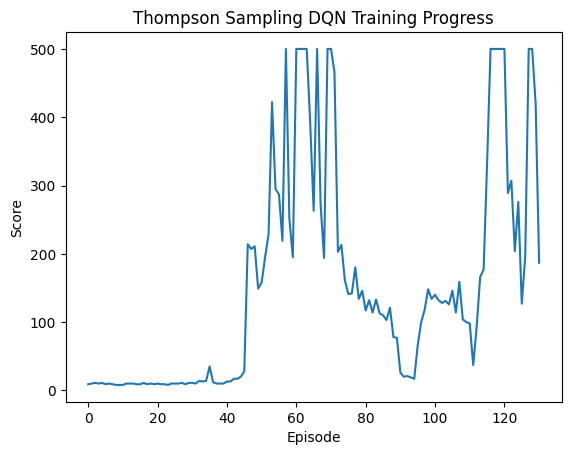

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
from collections import deque
import random

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Outputs Q-values for each action

class ThompsonDQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=256,
                 gamma=0.99, lr=0.001, batch_size=64,
                 memory_size=10000, target_update_freq=10,
                 initial_alpha=1.0, initial_beta=1.0):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        # Main Q-Network and Target Q-Network
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.memory = deque(maxlen=memory_size)
        self.learn_step_counter = 0

        # Thompson Sampling parameters for each action
        self.alpha = np.ones(action_dim) * initial_alpha
        self.beta = np.ones(action_dim) * initial_beta

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        # Sample action probabilities using Beta distributions
        sampled_probs = np.array([np.random.beta(self.alpha[a], self.beta[a]) for a in range(self.action_dim)])

        # Select action with the highest sampled value
        with torch.no_grad():
            q_values = self.q_network(state).cpu().numpy()[0]
            weighted_q_values = q_values * sampled_probs
            return np.argmax(weighted_q_values)

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

        # Update Thompson Sampling parameters
        if reward > 0:
            self.alpha[action] += 1
        else:
            self.beta[action] += 1

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Current Q-values
        q_values = self.q_network(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()

        # Target Q-values
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        # Loss and backpropagation
        loss = F.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

def train_thompson_dqn(env_name='CartPole-v1', episodes=1000, max_steps=500):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ThompsonDQNAgent(state_dim, action_dim)

    scores = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.store_transition(state, action, reward, next_state, done)
            agent.learn()

            total_reward += reward
            state = next_state

            if done:
                break

        scores.append(total_reward)
        if (episode + 1) % 10 == 0:
            avg_score = np.mean(scores[-10:])
            print(f"Episode {episode + 1}, Average Score: {avg_score}")

        # Check for solving criteria
        if np.mean(scores[-100:]) >= 195.0:  # Solved when average score over last 100 episodes >= 195
            print(f"Solved at Episode {episode + 1}")
            break

    return agent, scores

if __name__ == "__main__":
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    agent, scores = train_thompson_dqn(episodes=1000)

    import matplotlib.pyplot as plt
    plt.plot(scores)
    plt.title('Thompson Sampling DQN Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.show()


Episode 10, Average Score: 9.3
Episode 20, Average Score: 9.7
Episode 30, Average Score: 10.2
Episode 40, Average Score: 9.0
Episode 50, Average Score: 9.9
Episode 60, Average Score: 10.3
Episode 70, Average Score: 10.2
Episode 80, Average Score: 9.9
Episode 90, Average Score: 10.4
Episode 100, Average Score: 13.6
Episode 110, Average Score: 29.2
Episode 120, Average Score: 10.2
Episode 130, Average Score: 10.2
Episode 140, Average Score: 12.8
Episode 150, Average Score: 12.4
Episode 160, Average Score: 11.3
Episode 170, Average Score: 14.3
Episode 180, Average Score: 17.6
Episode 190, Average Score: 43.7
Episode 200, Average Score: 44.3
Episode 210, Average Score: 37.0
Episode 220, Average Score: 27.3
Episode 230, Average Score: 41.2
Episode 240, Average Score: 40.8
Episode 250, Average Score: 48.0
Episode 260, Average Score: 63.5
Episode 270, Average Score: 41.0
Episode 280, Average Score: 48.6
Episode 290, Average Score: 60.1
Episode 300, Average Score: 40.8
Episode 310, Average Sco

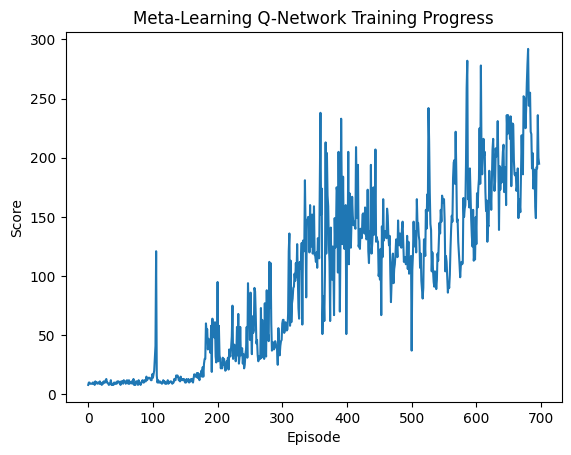

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
from collections import deque, OrderedDict
import random

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Outputs Q-values for each action

class MetaQ:
    def __init__(self, state_dim, action_dim, hidden_dim=256,
                 inner_lr=0.01, meta_lr=0.001, gamma=0.99,
                 memory_size=10000, batch_size=64,
                 target_update_freq=10, num_tasks=5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Meta Q-Network and Target Q-Network
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.meta_optimizer = optim.Adam(self.q_network.parameters(), lr=meta_lr)
        self.gamma = gamma
        self.inner_lr = inner_lr
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.memory = deque(maxlen=memory_size)
        self.num_tasks = num_tasks
        self.learn_step_counter = 0

    def select_action(self, state, epsilon=0.1):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if random.random() > epsilon:
            with torch.no_grad():
                return torch.argmax(self.q_network(state)).item()
        else:
            return random.randrange(self.q_network.fc3.out_features)

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def prepare_batch(self, batch):
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        return states, actions, rewards, next_states, dones

    def inner_loop_update(self, task_batch):
        # Perform task-specific updates
        states, actions, rewards, next_states, dones = self.prepare_batch(task_batch)

        # Compute Q-values
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        # Compute loss
        loss = F.mse_loss(q_values, target_q_values)

        # Update parameters using a temporary optimizer
        grads = torch.autograd.grad(loss, self.q_network.parameters())
        updated_params = OrderedDict()
        for (name, param), grad in zip(self.q_network.named_parameters(), grads):
            updated_params[name] = param - self.inner_lr * grad

        return updated_params

    def meta_update(self):
        if len(self.memory) < self.batch_size * 2 * self.num_tasks:
            return

        meta_loss = 0
        self.meta_optimizer.zero_grad()

        for _ in range(self.num_tasks):
            # Sample task-specific batches
            task_start = random.randint(0, len(self.memory) - self.batch_size * 2)
            task_batch = list(self.memory)[task_start:task_start + self.batch_size]
            eval_batch = list(self.memory)[task_start + self.batch_size:task_start + self.batch_size * 2]

            # Inner loop: Perform task-specific updates
            updated_params = self.inner_loop_update(task_batch)

            # Temporarily apply updated parameters
            original_params = OrderedDict((name, param.clone()) for name, param in self.q_network.named_parameters())
            for name, param in self.q_network.named_parameters():
                param.data = updated_params[name].data

            # Evaluate on evaluation batch
            states, actions, rewards, next_states, dones = self.prepare_batch(eval_batch)
            q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
            with torch.no_grad():
                max_next_q_values = self.target_network(next_states).max(1)[0]
                target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

            # Meta loss
            task_meta_loss = F.mse_loss(q_values, target_q_values)
            meta_loss += task_meta_loss

            # Revert to original parameters
            for name, param in self.q_network.named_parameters():
                param.data = original_params[name].data

        # Outer loop: Meta optimization
        meta_loss = meta_loss / self.num_tasks
        meta_loss.backward()
        self.meta_optimizer.step()

        # Update target network
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        #print(f"Meta Loss: {meta_loss.item()}")

def train_meta_q(env_name='CartPole-v1', episodes=1000, max_steps=500):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = MetaQ(state_dim, action_dim)

    scores = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.store_transition(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state

            if done:
                break

        scores.append(total_reward)

        # Meta-update after each episode
        agent.meta_update()

        if (episode + 1) % 10 == 0:
            avg_score = np.mean(scores[-10:])
            print(f"Episode {episode + 1}, Average Score: {avg_score}")

        # Check for solving criteria
        if np.mean(scores[-100:]) >= 195.0:  # Solved when average score over last 100 episodes >= 195
            print(f"Solved at Episode {episode + 1}")
            break

    return agent, scores

if __name__ == "__main__":
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    agent, scores = train_meta_q(episodes=1000)

    import matplotlib.pyplot as plt
    plt.plot(scores)
    plt.title('Meta-Learning Q-Network Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.show()


(obj pid=111280) Episode 50, Average Score: 9.4
(obj pid=111280) Episode 100, Average Score: 9.4
(obj pid=111280) Episode 150, Average Score: 9.42
(obj pid=111280) Episode 200, Average Score: 9.32


(obj pid=111280) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=111280) Episode 250, Average Score: 9.2
(obj pid=111280) Episode 300, Average Score: 9.32
(obj pid=68456) Episode 50, Average Score: 9.3
(obj pid=111280) Episode 350, Average Score: 9.2


(obj pid=68456) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107296) Episode 50, Average Score: 9.18 [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


(obj pid=107296) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=104656) Episode 50, Average Score: 9.18 [repeated 7x across cluster]


(obj pid=104656) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
(obj pid=103772) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=103772) Episode 50, Average Score: 12.66 [repeated 10x across cluster]
(obj pid=99904) Episode 50, Average Score: 9.4 [repeated 6x across cluster]


(obj pid=99904) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=108552) Episode 50, Average Score: 11.48 [repeated 6x across cluster]


(obj pid=108552) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=108552) Episode 300, Average Score: 9.72 [repeated 5x across cluster]


(obj pid=82664) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
(obj pid=90984) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=90984) Episode 50, Average Score: 9.42 [repeated 7x across cluster]
(obj pid=105840) Episode 50, Average Score: 9.48 [repeated 6x across cluster]


(obj pid=105840) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=85556) Episode 50, Average Score: 17.82 [repeated 5x across cluster]


(obj pid=85556) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=85556) Episode 350, Average Score: 60.52 [repeated 7x across cluster]


(obj pid=56108) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=56108) Episode 350, Average Score: 43.72 [repeated 8x across cluster]


(obj pid=106988) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=99096) Episode 50, Average Score: 11.1 [repeated 7x across cluster]


(obj pid=99096) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=99096) Episode 250, Average Score: 133.34 [repeated 7x across cluster]
(obj pid=99096) Episode 400, Average Score: 113.36 [repeated 9x across cluster]
(obj pid=86936) Episode 50, Average Score: 10.34 [repeated 7x across cluster]


(obj pid=86936) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=82764) Episode 50, Average Score: 28.62 [repeated 6x across cluster]
(obj pid=92508) Episode 50, Average Score: 9.18 [repeated 4x across cluster]


(obj pid=92508) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.) [repeated 2x across cluster]


(obj pid=82764) Episode 350, Average Score: 83.36 [repeated 7x across cluster]


(obj pid=68328) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=68328) Episode 300, Average Score: 9.42 [repeated 8x across cluster]


(obj pid=69640) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=69640) Episode 300, Average Score: 9.42 [repeated 6x across cluster]


(obj pid=31176) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=31176) Episode 200, Average Score: 9.32 [repeated 4x across cluster]


(obj pid=108996) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=31176) Episode 300, Average Score: 9.32 [repeated 5x across cluster]


(obj pid=108488) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=108488) Episode 150, Average Score: 10.64 [repeated 5x across cluster]


(obj pid=111472) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=111472) Episode 150, Average Score: 9.42 [repeated 5x across cluster]


(obj pid=108292) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=111472) Episode 200, Average Score: 9.34 [repeated 3x across cluster]
(obj pid=111472) Episode 250, Average Score: 9.42 [repeated 5x across cluster]


(obj pid=102108) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=111472) Episode 300, Average Score: 9.42 [repeated 7x across cluster]


(obj pid=107032) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107032) Episode 100, Average Score: 14.48 [repeated 8x across cluster]


(obj pid=109252) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107032) Episode 250, Average Score: 73.82 [repeated 5x across cluster]
(obj pid=109252) Episode 200, Average Score: 80.76 [repeated 5x across cluster]


(obj pid=105864) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=109252) Episode 350, Average Score: 105.42 [repeated 10x across cluster]


(obj pid=107072) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107072) Episode 300, Average Score: 9.42 [repeated 8x across cluster]


(obj pid=108232) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=108232) Episode 200, Average Score: 30.42 [repeated 4x across cluster]


(obj pid=69812) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=69812) Episode 250, Average Score: 9.2 [repeated 8x across cluster]


(obj pid=76424) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=76424) Episode 200, Average Score: 46.88 [repeated 6x across cluster]


(obj pid=95828) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=95828) Episode 200, Average Score: 9.34 [repeated 6x across cluster]


(obj pid=105832) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=105832) Episode 200, Average Score: 9.32 [repeated 8x across cluster]


(obj pid=107964) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107964) Episode 200, Average Score: 9.32 [repeated 6x across cluster]


(obj pid=51972) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=51972) Episode 200, Average Score: 9.84 [repeated 6x across cluster]


(obj pid=18136) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=18136) Episode 200, Average Score: 9.32 [repeated 6x across cluster]


(obj pid=86188) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=86188) Episode 200, Average Score: 9.32 [repeated 6x across cluster]


(obj pid=69004) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=69004) Episode 200, Average Score: 9.32 [repeated 6x across cluster]


(obj pid=110352) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=110352) Episode 200, Average Score: 9.32 [repeated 6x across cluster]


(obj pid=84216) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=84216) Episode 100, Average Score: 14.28 [repeated 4x across cluster]


(obj pid=111944) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=111944) Episode 150, Average Score: 9.36 [repeated 6x across cluster]


(obj pid=112120) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=84216) Episode 400, Average Score: 165.26 [repeated 8x across cluster]
(obj pid=78324) Episode 50, Average Score: 9.5 [repeated 5x across cluster]


(obj pid=78324) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=102596) Episode 50, Average Score: 11.52 [repeated 5x across cluster]


(obj pid=102596) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=2528) Episode 50, Average Score: 10.7 [repeated 9x across cluster]


(obj pid=2528) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=109860) Episode 50, Average Score: 9.34 [repeated 6x across cluster]


(obj pid=109860) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=50864) Episode 50, Average Score: 9.18 [repeated 8x across cluster]
(obj pid=107032) Episode 50, Average Score: 9.42 [repeated 6x across cluster]
(obj pid=54060) Episode 50, Average Score: 9.18 [repeated 6x across cluster]


(obj pid=54060) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=76680) Episode 50, Average Score: 9.54 [repeated 5x across cluster]


(obj pid=76680) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=76680) Episode 250, Average Score: 17.16 [repeated 5x across cluster]


(obj pid=107356) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107356) Episode 200, Average Score: 9.32 [repeated 5x across cluster]


(obj pid=111708) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=111708) Episode 150, Average Score: 11.32 [repeated 5x across cluster]


(obj pid=62564) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=62564) Episode 150, Average Score: 9.42 [repeated 6x across cluster]


(obj pid=66540) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=66540) Episode 100, Average Score: 16.64 [repeated 5x across cluster]


(obj pid=68800) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=68800) Episode 150, Average Score: 9.42 [repeated 7x across cluster]


(obj pid=1176) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=1176) Episode 150, Average Score: 9.36 [repeated 6x across cluster]


(obj pid=110684) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=1176) Episode 300, Average Score: 43.7 [repeated 3x across cluster]
(obj pid=110684) Episode 200, Average Score: 74.48 [repeated 6x across cluster]


(obj pid=105368) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=110684) Episode 350, Average Score: 125.14 [repeated 5x across cluster]
(obj pid=112044) Episode 50, Average Score: 9.4 [repeated 3x across cluster]


(obj pid=112044) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=105368) Episode 250, Average Score: 9.2 [repeated 3x across cluster]


(obj pid=58068) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=58068) Episode 100, Average Score: 9.44 [repeated 5x across cluster]
(obj pid=58068) Episode 200, Average Score: 15.6 [repeated 10x across cluster]


(obj pid=100856) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=100856) Episode 200, Average Score: 30.78 [repeated 5x across cluster]


(obj pid=108832) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=58068) Episode 350, Average Score: 23.44 [repeated 7x across cluster]


(obj pid=111292) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=111292) Episode 150, Average Score: 11.46 [repeated 9x across cluster]


(obj pid=37856) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=37856) Episode 50, Average Score: 9.64 [repeated 3x across cluster]
(obj pid=97188) Episode 50, Average Score: 9.4 [repeated 7x across cluster]


(obj pid=97188) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=105708) Episode 50, Average Score: 9.68 [repeated 5x across cluster]


(obj pid=105708) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=105708) Episode 300, Average Score: 11.72 [repeated 8x across cluster]


(obj pid=111852) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=111852) Episode 300, Average Score: 9.32 [repeated 6x across cluster]


(obj pid=28548) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
(obj pid=70220) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=70220) Episode 50, Average Score: 23.58 [repeated 7x across cluster]
(obj pid=70220) Episode 250, Average Score: 41.06 [repeated 4x across cluster]


(obj pid=106292) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=106292) Episode 200, Average Score: 41.96 [repeated 7x across cluster]


(obj pid=52568) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=52568) Episode 250, Average Score: 9.2 [repeated 8x across cluster]


(obj pid=33448) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=33448) Episode 250, Average Score: 9.42 [repeated 7x across cluster]


(obj pid=26432) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=26432) Episode 200, Average Score: 55.32 [repeated 5x across cluster]


(obj pid=70576) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=70576) Episode 250, Average Score: 10.94 [repeated 7x across cluster]
(obj pid=47344) Episode 50, Average Score: 10.24 [repeated 10x across cluster]


(obj pid=47344) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=47344) Episode 300, Average Score: 21.66 [repeated 5x across cluster]


(obj pid=63192) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=105108) Episode 50, Average Score: 9.2 [repeated 7x across cluster]


(obj pid=105108) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=71160) Episode 50, Average Score: 10.0 [repeated 6x across cluster]


(obj pid=71160) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=71160) Episode 400, Average Score: 56.62 [repeated 7x across cluster]


(obj pid=24880) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=24880) Episode 350, Average Score: 89.78 [repeated 7x across cluster]


(obj pid=63584) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=68632) Episode 50, Average Score: 24.9 [repeated 8x across cluster]


(obj pid=68632) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=108676) Episode 50, Average Score: 9.3 [repeated 5x across cluster]
(obj pid=22180) Episode 50, Average Score: 9.4 [repeated 7x across cluster]


(obj pid=22180) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=109724) Episode 50, Average Score: 21.68 [repeated 6x across cluster]
(obj pid=109724) Episode 250, Average Score: 27.86 [repeated 4x across cluster]


(obj pid=106100) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.) [repeated 2x across cluster]


(obj pid=106100) Episode 250, Average Score: 14.62 [repeated 6x across cluster]


(obj pid=104196) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=104196) Episode 300, Average Score: 9.42 [repeated 7x across cluster]


(obj pid=44344) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=44344) Episode 250, Average Score: 9.42 [repeated 5x across cluster]


(obj pid=24176) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=106988) Episode 50, Average Score: 9.18 [repeated 8x across cluster]


(obj pid=106988) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=105904) Episode 50, Average Score: 9.38 [repeated 6x across cluster]


(obj pid=105904) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=100856) Episode 50, Average Score: 10.18 [repeated 6x across cluster]


(obj pid=100856) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=100856) Episode 400, Average Score: 76.96 [repeated 7x across cluster]


(obj pid=71460) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=50012) Episode 50, Average Score: 9.34 [repeated 7x across cluster]


(obj pid=50012) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=50012) Episode 400, Average Score: 253.76 [repeated 7x across cluster]


(obj pid=106876) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=106876) Episode 300, Average Score: 59.0 [repeated 6x across cluster]


(obj pid=107964) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107964) Episode 250, Average Score: 9.2 [repeated 7x across cluster]


(obj pid=111576) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=111576) Episode 250, Average Score: 62.5 [repeated 6x across cluster]


(obj pid=112460) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=112460) Episode 200, Average Score: 21.96 [repeated 7x across cluster]


(obj pid=48348) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=48348) Episode 150, Average Score: 16.86 [repeated 5x across cluster]


(obj pid=106184) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=106184) Episode 200, Average Score: 9.34 [repeated 8x across cluster]


(obj pid=108032) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=108032) Episode 100, Average Score: 9.4 [repeated 6x across cluster]


(obj pid=111344) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=108032) Episode 400, Average Score: 74.24 [repeated 7x across cluster]
(obj pid=111344) Episode 200, Average Score: 59.18 [repeated 4x across cluster]


(obj pid=70112) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=103236) Episode 50, Average Score: 9.6 [repeated 9x across cluster]


(obj pid=103236) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=103236) Episode 300, Average Score: 54.66 [repeated 7x across cluster]


(obj pid=104148) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=103236) Episode 400, Average Score: 143.9 [repeated 7x across cluster]


(obj pid=110168) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=110168) Episode 250, Average Score: 9.42 [repeated 6x across cluster]


(obj pid=36784) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=36784) Episode 250, Average Score: 9.42 [repeated 6x across cluster]


(obj pid=8456) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=8456) Episode 250, Average Score: 9.22 [repeated 6x across cluster]


(obj pid=102720) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=102720) Episode 250, Average Score: 39.2 [repeated 6x across cluster]


(obj pid=67548) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=67548) Episode 250, Average Score: 9.42 [repeated 7x across cluster]


(obj pid=88172) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=88172) Episode 250, Average Score: 9.42 [repeated 7x across cluster]


(obj pid=90220) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=90220) Episode 200, Average Score: 22.12 [repeated 5x across cluster]


(obj pid=109876) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=90220) Episode 350, Average Score: 70.7 [repeated 6x across cluster]


(obj pid=86248) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=86248) Episode 150, Average Score: 9.36 [repeated 7x across cluster]


(obj pid=105132) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=105132) Episode 100, Average Score: 15.36 [repeated 7x across cluster]
(obj pid=105212) Episode 150, Average Score: 9.36 [repeated 6x across cluster]


(obj pid=105212) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=111164) Episode 50, Average Score: 9.4 [repeated 6x across cluster]


(obj pid=111164) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=111164) Episode 300, Average Score: 10.06 [repeated 6x across cluster]


(obj pid=103460) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=103460) Episode 100, Average Score: 25.08 [repeated 2x across cluster]


(obj pid=97164) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=103460) Episode 150, Average Score: 58.1 [repeated 4x across cluster]


(obj pid=105672) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=105672) Episode 150, Average Score: 9.42 [repeated 4x across cluster]
(obj pid=97164) Episode 250, Average Score: 28.56 [repeated 4x across cluster]


(obj pid=8496) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=97164) Episode 300, Average Score: 46.84 [repeated 6x across cluster]


(obj pid=102984) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=97164) Episode 350, Average Score: 38.86 [repeated 7x across cluster]
(obj pid=97164) Episode 400, Average Score: 40.34 [repeated 4x across cluster]


(obj pid=108652) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=103460) Solved at Episode 357
(obj pid=108652) Episode 200, Average Score: 12.22 [repeated 6x across cluster]


(obj pid=71804) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=71804) Episode 250, Average Score: 9.42 [repeated 7x across cluster]


(obj pid=111400) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=111400) Episode 150, Average Score: 9.36 [repeated 6x across cluster]


(obj pid=70280) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=70280) Episode 200, Average Score: 11.04 [repeated 5x across cluster]


(obj pid=13964) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=13964) Episode 250, Average Score: 18.02 [repeated 8x across cluster]
(obj pid=70440) Episode 50, Average Score: 32.9 [repeated 2x across cluster]


(obj pid=70440) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=48532) Episode 50, Average Score: 9.2 [repeated 4x across cluster]
(obj pid=70440) Episode 200, Average Score: 9.32 [repeated 6x across cluster]


(obj pid=70892) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=70892) Episode 200, Average Score: 9.44 [repeated 4x across cluster]


(obj pid=77044) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=77044) Episode 250, Average Score: 9.2 [repeated 8x across cluster]


(obj pid=75720) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=75720) Episode 250, Average Score: 9.42 [repeated 6x across cluster]


(obj pid=8916) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=8916) Episode 100, Average Score: 11.32 [repeated 4x across cluster]


(obj pid=102940) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=8916) Episode 250, Average Score: 15.66 [repeated 7x across cluster]
(obj pid=56812) Episode 100, Average Score: 9.34 [repeated 6x across cluster]


(obj pid=56812) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=56812) Episode 250, Average Score: 9.42 [repeated 4x across cluster]


(obj pid=107352) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107352) Episode 250, Average Score: 48.1 [repeated 6x across cluster]


(obj pid=108916) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107352) Episode 350, Average Score: 80.24 [repeated 6x across cluster]


(obj pid=80952) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=80952) Episode 200, Average Score: 34.0 [repeated 7x across cluster]


(obj pid=108832) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=108832) Episode 200, Average Score: 40.96 [repeated 6x across cluster]


(obj pid=111436) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=111436) Episode 200, Average Score: 10.38 [repeated 8x across cluster]


(obj pid=105840) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=105840) Episode 150, Average Score: 9.86 [repeated 7x across cluster]


(obj pid=108144) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=105840) Episode 300, Average Score: 46.14 [repeated 5x across cluster]
(obj pid=108144) Episode 300, Average Score: 9.42 [repeated 6x across cluster]


(obj pid=111448) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=112528) Episode 50, Average Score: 9.18 [repeated 6x across cluster]


(obj pid=112528) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=112528) Episode 300, Average Score: 16.7 [repeated 8x across cluster]


(obj pid=7268) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=105244) Episode 50, Average Score: 9.18 [repeated 6x across cluster]


(obj pid=105244) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=105244) Episode 300, Average Score: 9.42 [repeated 6x across cluster]


(obj pid=110896) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=110896) Episode 400, Average Score: 147.26 [repeated 8x across cluster]


(obj pid=49500) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=49500) Episode 350, Average Score: 83.96 [repeated 7x across cluster]


(obj pid=52512) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=52512) Episode 50, Average Score: 9.4 [repeated 8x across cluster]


(obj pid=97656) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=97656) Episode 50, Average Score: 23.88 [repeated 6x across cluster]
(obj pid=97656) Episode 350, Average Score: 146.68 [repeated 6x across cluster]


(obj pid=112504) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=112504) Episode 350, Average Score: 74.8 [repeated 8x across cluster]


(obj pid=76228) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
(obj pid=13128) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=13128) Episode 50, Average Score: 9.18 [repeated 8x across cluster]


(obj pid=105172) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=105172) Episode 50, Average Score: 9.82 [repeated 6x across cluster]


(obj pid=104212) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=104212) Episode 50, Average Score: 22.68 [repeated 8x across cluster]
(obj pid=104212) Episode 400, Average Score: 88.72 [repeated 7x across cluster]


(obj pid=110776) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=110776) Episode 350, Average Score: 66.88 [repeated 7x across cluster]


(obj pid=96940) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
(obj pid=22180) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=22180) Episode 50, Average Score: 9.4 [repeated 8x across cluster]
(obj pid=109272) Episode 50, Average Score: 9.18 [repeated 6x across cluster]


(obj pid=109272) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=37856) Episode 50, Average Score: 9.18 [repeated 5x across cluster]


(obj pid=37856) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=112292) Episode 50, Average Score: 9.4 [repeated 6x across cluster]


(obj pid=112292) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=32404) Episode 50, Average Score: 9.4 [repeated 6x across cluster]


(obj pid=32404) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=17744) Episode 50, Average Score: 9.18 [repeated 6x across cluster]


(obj pid=17744) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=58348) Episode 50, Average Score: 9.54 [repeated 7x across cluster]


(obj pid=52496) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=52496) Episode 50, Average Score: 9.68 [repeated 6x across cluster]
(obj pid=52496) Episode 250, Average Score: 9.2 [repeated 4x across cluster]


(obj pid=48836) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=48836) Episode 200, Average Score: 18.7 [repeated 5x across cluster]


(obj pid=8456) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=48836) Episode 350, Average Score: 53.72 [repeated 7x across cluster]


(obj pid=108756) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=108756) Episode 200, Average Score: 9.4 [repeated 6x across cluster]


(obj pid=110388) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=8456) Episode 300, Average Score: 11.38 [repeated 4x across cluster]
(obj pid=110388) Episode 200, Average Score: 9.18 [repeated 3x across cluster]


(obj pid=18548) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=18548) Episode 250, Average Score: 9.2 [repeated 7x across cluster]


(obj pid=102524) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=102524) Episode 200, Average Score: 10.98 [repeated 5x across cluster]


(obj pid=70332) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=70332) Episode 200, Average Score: 20.22 [repeated 6x across cluster]


(obj pid=76444) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=76444) Episode 200, Average Score: 9.34 [repeated 6x across cluster]


(obj pid=101984) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=101984) Episode 150, Average Score: 9.94 [repeated 7x across cluster]
(obj pid=22208) Episode 50, Average Score: 9.62 [repeated 3x across cluster]


(obj pid=22208) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=101984) Episode 400, Average Score: 113.86 [repeated 7x across cluster]


(obj pid=84752) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=84752) Episode 250, Average Score: 30.62 [repeated 6x across cluster]


(obj pid=112228) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=112228) Episode 250, Average Score: 9.42 [repeated 7x across cluster]


(obj pid=71156) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=71156) Episode 200, Average Score: 34.66 [repeated 6x across cluster]


(obj pid=96732) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=96732) Episode 200, Average Score: 9.32 [repeated 6x across cluster]


(obj pid=82196) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=82196) Episode 150, Average Score: 9.42 [repeated 7x across cluster]
(obj pid=82196) Episode 300, Average Score: 9.32 [repeated 3x across cluster]


(obj pid=107744) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=102760) Episode 50, Average Score: 9.54 [repeated 6x across cluster]


(obj pid=102760) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107744) Episode 400, Average Score: 135.48 [repeated 7x across cluster]


(obj pid=107540) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107540) Episode 250, Average Score: 42.56 [repeated 7x across cluster]


(obj pid=68520) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107540) Episode 350, Average Score: 181.6 [repeated 7x across cluster]


(obj pid=110780) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=110780) Episode 200, Average Score: 9.34 [repeated 7x across cluster]


(obj pid=60592) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=60592) Episode 200, Average Score: 53.36 [repeated 6x across cluster]


(obj pid=106352) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=60592) Episode 350, Average Score: 59.38 [repeated 6x across cluster]
(obj pid=35816) Episode 50, Average Score: 9.54 [repeated 11x across cluster]
(obj pid=18916) Episode 50, Average Score: 9.18 [repeated 6x across cluster]


(obj pid=18916) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=18916) Episode 300, Average Score: 9.42 [repeated 5x across cluster]


(obj pid=90284) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=90284) Episode 300, Average Score: 9.32 [repeated 6x across cluster]


(obj pid=68792) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=68792) Episode 300, Average Score: 9.32 [repeated 6x across cluster]


(obj pid=103608) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
(obj pid=109108) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=103608) Episode 300, Average Score: 83.1 [repeated 6x across cluster]
(obj pid=103608) Episode 400, Average Score: 122.12 [repeated 8x across cluster]


(obj pid=21888) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
(obj pid=109812) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=109812) Episode 50, Average Score: 9.42 [repeated 9x across cluster]
(obj pid=101528) Episode 50, Average Score: 9.54 [repeated 6x across cluster]


(obj pid=101528) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=99228) Episode 50, Average Score: 9.4 [repeated 6x across cluster]


(obj pid=99228) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=41780) Episode 50, Average Score: 9.3 [repeated 6x across cluster]


(obj pid=41780) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=41780) Episode 300, Average Score: 187.98 [repeated 5x across cluster]


(obj pid=31656) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=110208) Episode 50, Average Score: 9.4 [repeated 8x across cluster]


(obj pid=110208) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=31656) Episode 400, Average Score: 85.36 [repeated 7x across cluster]


(obj pid=77416) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107208) Episode 50, Average Score: 9.58 [repeated 8x across cluster]


(obj pid=107208) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107208) Episode 300, Average Score: 47.74 [repeated 5x across cluster]


(obj pid=7652) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=7652) Episode 200, Average Score: 39.06 [repeated 6x across cluster]


(obj pid=103240) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=7652) Episode 300, Average Score: 98.4 [repeated 5x across cluster]


(obj pid=102964) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=102964) Episode 100, Average Score: 24.04 [repeated 4x across cluster]


(obj pid=78884) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=78884) Episode 100, Average Score: 9.4 [repeated 5x across cluster]
(obj pid=80200) Episode 50, Average Score: 9.28 [repeated 5x across cluster]


(obj pid=80200) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=80200) Episode 250, Average Score: 9.44 [repeated 7x across cluster]


(obj pid=59404) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=59404) Episode 250, Average Score: 9.2 [repeated 10x across cluster]


(obj pid=40700) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=40700) Episode 100, Average Score: 15.06 [repeated 4x across cluster]


(obj pid=69504) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=40700) Episode 200, Average Score: 69.78 [repeated 3x across cluster]
(obj pid=107144) Episode 50, Average Score: 9.94 [repeated 4x across cluster]


(obj pid=107144) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=69504) Episode 250, Average Score: 30.3 [repeated 4x across cluster]


(obj pid=108960) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=108960) Episode 100, Average Score: 13.5 [repeated 6x across cluster]


(obj pid=66504) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107144) Episode 300, Average Score: 52.68 [repeated 6x across cluster]


(obj pid=110064) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=110064) Episode 150, Average Score: 14.46 [repeated 8x across cluster]


(obj pid=107600) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107600) Episode 100, Average Score: 12.72 [repeated 6x across cluster]
(obj pid=66504) Episode 350, Average Score: 58.68 [repeated 5x across cluster]


(obj pid=81936) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=66504) Episode 400, Average Score: 57.66 [repeated 6x across cluster]


(obj pid=104212) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=104212) Episode 100, Average Score: 28.06 [repeated 7x across cluster]
(obj pid=10208) Episode 50, Average Score: 10.1 [repeated 7x across cluster]


(obj pid=10208) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=100712) Episode 50, Average Score: 9.42 [repeated 9x across cluster]


(obj pid=100712) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
(obj pid=86988) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=86988) Episode 50, Average Score: 9.18 [repeated 3x across cluster]


(obj pid=101568) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=100712) Episode 300, Average Score: 9.44 [repeated 8x across cluster]
(obj pid=61380) Episode 50, Average Score: 9.4 [repeated 7x across cluster]


(obj pid=61380) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=69552) Episode 50, Average Score: 9.3 [repeated 3x across cluster]


(obj pid=69552) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=14464) Episode 50, Average Score: 9.4 [repeated 5x across cluster]


(obj pid=14464) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=13400) Episode 50, Average Score: 9.22 [repeated 6x across cluster]


(obj pid=13400) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=13400) Episode 150, Average Score: 14.98 [repeated 4x across cluster]


(obj pid=108048) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=108048) Episode 100, Average Score: 31.2 [repeated 5x across cluster]


2024-11-25 11:02:28,301	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-11-25 11:02:28,637	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Benedict/ray_results/obj_2024-11-25_10-37-22' in 0.3360s.
(obj pid=107220) C:\Users\Benedict\AppData\Local\Temp\ipykernel_95128\135224036.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


(obj pid=107220) Solved at Episode 1
(obj pid=108048) Episode 300, Average Score: 31.96 [repeated 7x across cluster]


2024-11-25 11:02:33,472	INFO tune.py:1041 -- Total run time: 1498.13 seconds (1492.90 seconds for the tuning loop).
2024-11-25 11:02:33,472	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="C:/Users/Benedict/ray_results/obj_2024-11-25_10-37-22", trainable=...)
2024-11-25 11:02:37,889	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- obj_635dc2b1: FileNotFoundError('Could not fetch metrics for obj_635dc2b1: both result.json and progress.csv were not found at C:/Users/Benedict/ray_results/obj_2024-11-25_10-37-22/obj_635dc2b1')


Best params found: {'num_tasks': 19, 'inner_lr': 0.03200238470468728, 'meta_lr': 0.005559334381269848, 'hidden_dim': 512, 'memory_size': 20000, 'batch_size': 32, 'target_update_freq': 30}
Best score found: {'mean_reward': np.float64(377.3), 'timestamp': 1732499447, 'checkpoint_dir_name': None, 'done': True, 'training_iteration': 356, 'trial_id': '04542657', 'date': '2024-11-25_10-50-47', 'time_this_iter_s': 0.12251687049865723, 'time_total_s': 42.04860997200012, 'pid': 103460, 'hostname': 'Benovo', 'node_ip': '127.0.0.1', 'config': {'num_tasks': 19, 'inner_lr': 0.03200238470468728, 'meta_lr': 0.005559334381269848, 'hidden_dim': 512, 'memory_size': 20000, 'batch_size': 32, 'target_update_freq': 30}, 'time_since_restore': 42.04860997200012, 'iterations_since_restore': 356, 'experiment_tag': '122_batch_size=32,hidden_dim=512,inner_lr=0.0320,memory_size=20000,meta_lr=0.0056,num_tasks=19,target_update_freq=30'}


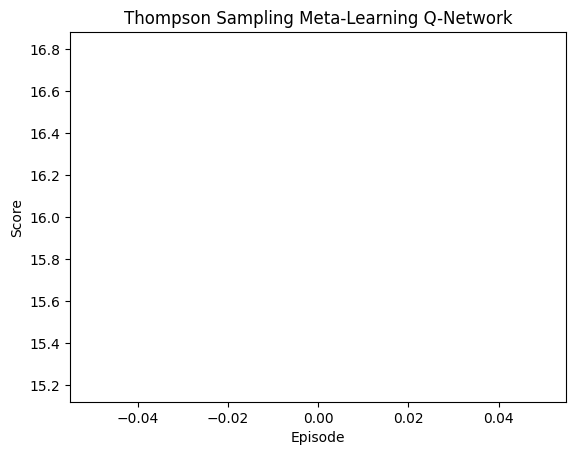

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
from collections import deque, OrderedDict
import random
from typing import Dict, Optional, Callable

from ray import train, tune
from ray.tune.search.optuna import OptunaSearch

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

        #we introduce a transform skip connection to allow for gradients to flow easier to the maml network during it's update.
        self.skip_transform = nn.Linear(state_dim, action_dim) 

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x) + self.skip_transform(state) # Outputs Q-values for each action

class ThompsonMetaQ:
    def __init__(self, state_dim, action_dim, hidden_dim=256,
                 inner_lr=0.01, meta_lr=0.001, gamma=0.99,
                 memory_size=10000, batch_size=64,
                 target_update_freq=10, num_tasks=5,
                 initial_alpha=1.0, initial_beta=1.0,
                 use_grokfast=True, grok_alpha=0.9, grok_lamb=0.8):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Underlying Q-Network
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        #for grokfast to enhance low gradients

        #possible anti-grok gradient filter
        self.use_grokfast: bool = False#use_grokfast #Set to False to disable Grokfast.
        self.meta_grads: Optional[Dict[str, torch.Tensor]] = None # Running memory (EMA). Initialize by setting it to None. Feed the output of the method recursively after on.
        self.grok_alpha: float = 0.0 #grok_alpha #Momentum hyperparmeter of the EMA.
        # self.grok_lamb: float = 0.5 #Amplifying factor hyperparameter of the filter.
        self.grok_lamb: Callable[[int, int], float] = 0.0 #grok_lamb
        #lambda episode, max: 1.0 - 0.5*np.cos(episode * np.pi / (max/2))
        # #Amplifying factor hyperparameter of the filter.

        # and Meta Q-Network
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.meta_optimizer = optim.Adam(self.q_network.parameters(), lr=meta_lr)
        self.gamma = gamma
        self.inner_lr = inner_lr
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.memory = deque(maxlen=memory_size)
        self.num_tasks = num_tasks
        self.learn_step_counter = 0
        self.delta = 0.01

        # Initialize Thompson Sampling parameters for each action
        self.alpha = np.ones(action_dim) * initial_alpha
        self.beta = np.ones(action_dim) * initial_beta

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        # Get Q-values
        with torch.no_grad():
            q_values = self.q_network(state).cpu().numpy()[0]

        # Sample probabilities using Thompson Sampling
        sampled_probs = np.array([np.random.beta(self.alpha[a], self.beta[a]) for a in range(len(q_values))])

        # Select action based on weighted Q-values
        weighted_q_values = q_values * sampled_probs
        return np.argmax(weighted_q_values)

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

        # Update Thompson Sampling parameters
        if reward > 0:
            self.alpha[action] += 1  # Rewarded actions increase alpha
        else:
            self.beta[action] += 1  # Unsuccessful actions increase beta

    def prepare_batch(self, batch):
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        return states, actions, rewards, next_states, dones

    def inner_loop_update(self, task_batch):
        # Perform task-specific updates
        states, actions, rewards, next_states, dones = self.prepare_batch(task_batch)

        # Compute Q-values
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        # Compute loss
        loss = F.mse_loss(q_values, target_q_values)
        loss += self.delta

        # Update parameters using a temporary optimizer
        grads = torch.autograd.grad(loss, self.q_network.parameters())
        updated_params = OrderedDict()
        for (name, param), grad in zip(self.q_network.named_parameters(), grads):
            updated_params[name] = param - self.inner_lr * grad

        return updated_params

    def meta_update(self):
        if len(self.memory) < self.batch_size * 2 * self.num_tasks:
            return

        meta_loss = 0
        self.meta_optimizer.zero_grad()

        for t in range(self.num_tasks):
            # Sample task-specific batches
            task_start = random.randint(0, len(self.memory) - self.batch_size * 2)
            task_batch = list(self.memory)[task_start                 : task_start+self.batch_size]
            eval_batch = list(self.memory)[task_start+self.batch_size : task_start+self.batch_size*2]

            # Inner loop: Perform task-specific updates
            updated_params = self.inner_loop_update(task_batch)

            # Temporarily apply updated parameters
            original_params = OrderedDict((name, param.clone()) for name, param in self.q_network.named_parameters())
            for name, param in self.q_network.named_parameters():
                param.data = updated_params[name].data

            # Evaluate on evaluation batch
            states, actions, rewards, next_states, dones = self.prepare_batch(eval_batch)
            q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
            with torch.no_grad():
                max_next_q_values = self.target_network(next_states).max(1)[0]
                target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

            # Meta loss
            task_meta_loss = F.mse_loss(q_values, target_q_values)
            meta_loss += task_meta_loss

            # Revert to original parameters
            for name, param in self.q_network.named_parameters():
                param.data = original_params[name].data

        # Outer loop: Meta optimization
        meta_loss = meta_loss / self.num_tasks
        meta_loss.backward()
        if self.use_grokfast:
            self.meta_grads = gradfilter_ema(
                self.q_network, 
                grads=self.meta_grads, 
                alpha=self.grok_alpha, 
                # lamb=self.grok_lamb(t, self.num_tasks)
                lamb=0.9,
            )
        self.meta_optimizer.step()

        # Update target network
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        #print(f"Meta Loss: {meta_loss.item()}")

def train_thompson_meta_q(env_name='CartPole-v1', episodes=1000, max_steps=500, **kwargs):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ThompsonMetaQ(state_dim, action_dim, **kwargs)

    scores = []
    for episode in range(episodes):
        state = env.reset(seed=episode)[0]
        total_reward = 0

        for _ in range(max_steps):
            action = agent.select_action(state)
            step = env.step(action)
            next_state, reward, done, _ = step[:4]

            agent.store_transition(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state

            if done:
                break

        scores.append(total_reward)

        # Meta-update after each episode
        agent.meta_update()

        if (episode + 1) % 50 == 0:
            avg_score = np.mean(scores[-50:])
            print(f"Episode {episode + 1}, Average Score: {avg_score}")

        # Check for solving criteria
        if np.mean(scores[-100:]) >= 300:  # Solved when average score over last 100 episodes >= 195
            print(f"Solved at Episode {episode + 1}")
            break

        return agent, scores
    
def obj(config): #same as above but now with optima hyperparameter optimization.
    env_name="CartPole-v1"
    episodes=1000
    max_steps=500

    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ThompsonMetaQ(state_dim, action_dim, **config)

    scores = []
    for episode in range(episodes):
        state = env.reset(seed=episode)[0]
        total_reward = 0

        for _ in range(max_steps):
            action = agent.select_action(state)
            step = env.step(action)
            next_state, reward, done, _ = step[:4]

            agent.store_transition(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state

            if done:
                break

        scores.append(total_reward)

        # Meta-update after each episode
        agent.meta_update()

        if (episode + 1) % 50 == 0:
            avg_score = np.mean(scores[-50:])
            print(f"Episode {episode + 1}, Average Score: {avg_score}")

        # Check for solving criteria
        if np.mean(scores[-100:]) >= 300:  # Solved when average score over last 100 episodes >= 195
            print(f"Solved at Episode {episode + 1}")
            break#

        train.report({"mean_reward":np.mean(scores[-50:])})


def opt_with_optima(iterations=200):
    hp_space = {
        "num_tasks": tune.randint(2, 20), 
        "inner_lr": tune.loguniform(0.0001, 0.1), 
        "meta_lr": tune.loguniform(0.0001, 0.1),
        "hidden_dim": tune.choice([64, 128, 256, 512]),
        "memory_size": tune.choice([10000, 20000, 50000]),
        "batch_size": tune.choice([32, 64, 128]),
        "target_update_freq": tune.randint(1, 100),
        "num_tasks": tune.randint(2, 20),
        # "use_grokfast": tune.choice([True, False]),
        # "grok_alpha": tune.uniform(0, 1),
        # "grok_lamb": tune.uniform(0, 2),
    } 

    algo = OptunaSearch()
    from ray.tune.stopper import TrialPlateauStopper#
    from ray.tune.schedulers import ASHAScheduler

    hbscheduler = ASHAScheduler(
        max_t=iterations,
        time_attr="training_iteration",
        grace_period=300,
        reduction_factor=3,
    )

    tuner = tune.Tuner(
        obj,
        tune_config=tune.TuneConfig(
            metric="mean_reward",
            mode="max",
            scheduler=hbscheduler,
            search_alg=algo,
            num_samples=iterations,
            trial_dirname_creator=lambda trial: f"{trial.trainable_name}_{trial.trial_id}",
        ),
        param_space=hp_space,
    )
    results = tuner.fit()
    return results.get_best_result().config, results.get_best_result().metrics

if __name__ == "__main__":
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    # agent, scores = train_thompson_meta_q(episodes=1000)

    optimal_params, score = opt_with_optima(iterations=400)

    print("Best params found:", optimal_params)
    print("Best score found:", score)


    agent, scores = train_thompson_meta_q(episodes=1000, **optimal_params)

    import matplotlib.pyplot as plt
    plt.plot(scores)
    plt.title('Thompson Sampling Meta-Learning Q-Network')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.show()
